In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold,RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from scipy.stats import randint
from scipy.stats import loguniform

**Import the data**

In [ ]:
df = pd.read_csv('/content/Dataset - Updated.csv')
df.shape

(1205, 6)

In [ ]:
df = df.drop(columns=['BS'])


**visual representation of the dataset**

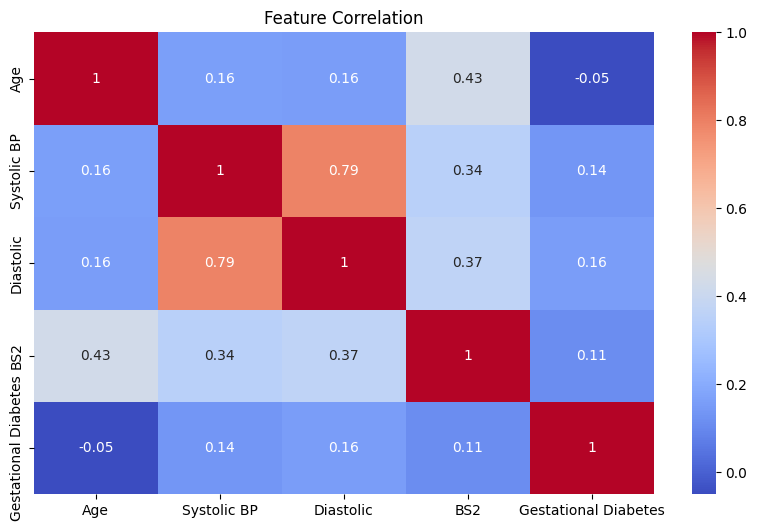

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

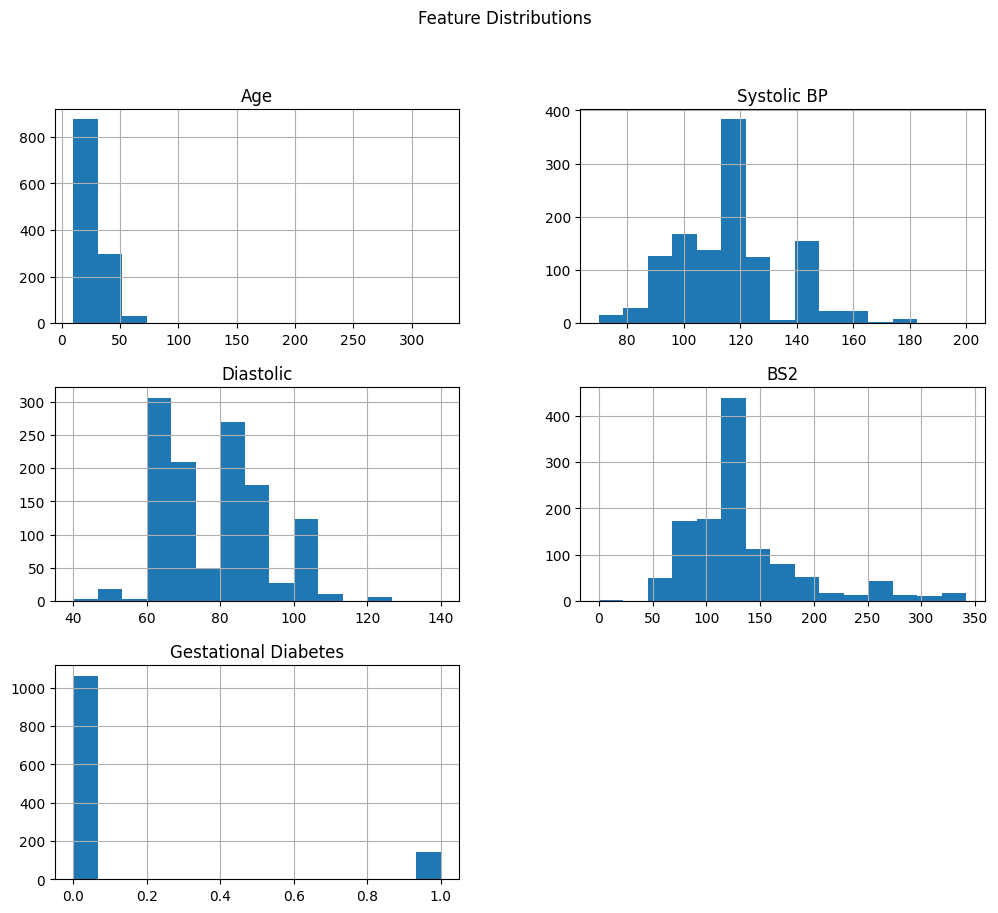

In [ ]:
df.hist(figsize=(12,10), bins=15)
plt.suptitle("Feature Distributions")
plt.show()

In [ ]:
df.isnull().sum()


Age                     0
Systolic BP             5
Diastolic               4
BS2                     0
Gestational Diabetes    0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
X = df.drop(columns=["Gestational Diabetes"])
y = df["Gestational Diabetes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def train_and_evaluate(model, params_list, X_train, X_test, y_train, y_test, model_name, scale_data=False):
    """
    Trains a model with multiple specified hyperparameter combinations, evaluates, and plots results.
    Returns a list of results for table creation.
    """
    print(f"\nüîç Training {model_name} with multiple param sets...")

    # Use scaled or unscaled data
    X_tr, X_te = (X_train_scaled, X_test_scaled) if scale_data else (X_train, X_test)

    # Cross-validation strategy for learning curve
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)

    # Debug: Print minority class counts
    print(f"Minority class counts in {model_name} folds:")
    for fold_idx, (train_idx, _) in enumerate(cv.split(X_tr, y_train)):
        minority_count = np.sum(y_train.iloc[train_idx] == 1)
        print(f"Fold {fold_idx + 1}: {minority_count} minority samples")
        if minority_count < 2:
            print(f"Warning: Fold {fold_idx + 1} has too few minority samples ({minority_count}).")

    results = []
    for i, params in enumerate(params_list, 1):
        print(f"\n--- {model_name} Experiment {i}: {params} ---")

        # Set model parameters
        model.set_params(**params)

        # Pipeline: SMOTE + model
        pipeline = Pipeline([
            ('smote', SMOTE(random_state=42, sampling_strategy=0.5, k_neighbors=1)),
            ('classifier', model)
        ])

        # Fit
        try:
            pipeline.fit(X_tr, y_train)
        except ValueError as e:
            print(f"Error in {model_name} Experiment {i}: {e}")
            continue

        # Predictions
        y_pred = pipeline.predict(X_te)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)

        print(f"Metrics - Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

        # Threshold tuning (for models with predict_proba)
        y_proba = None
        best_threshold = "N/A"
        best_f1 = f1
        best_y_pred = y_pred
        if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
            y_proba = pipeline.predict_proba(X_te)[:, 1]
            thresholds = np.arange(0.2, 0.8, 0.1)
            for thresh in thresholds:
                y_pred_thresh = (y_proba >= thresh).astype(int)
                f1_thresh = f1_score(y_test, y_pred_thresh)
                if f1_thresh > best_f1:
                    best_f1 = f1_thresh
                    best_threshold = thresh
                    best_y_pred = y_pred_thresh
                    acc = accuracy_score(y_test, y_pred_thresh)
                    prec = precision_score(y_test, y_pred_thresh)
                    rec = recall_score(y_test, y_pred_thresh)
            print(f"Best Threshold: {best_threshold}, Best F1: {best_f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(y_test, best_y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix - {model_name} (Experiment {i})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # ROC Curve
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(5,4))
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
            plt.plot([0,1],[0,1],"--", color="gray")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC - {model_name} (Experiment {i})")
            plt.legend(loc="lower right")
            plt.show()

        # Learning Curve
        train_sizes, train_scores, test_scores = learning_curve(
            pipeline, X_tr, y_train, cv=cv, scoring="f1",
            train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
        )
        plt.figure(figsize=(6,4))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="Train")
        plt.plot(train_sizes, np.mean(test_scores, axis=1), "o-", label="CV")
        plt.xlabel("Training Examples")
        plt.ylabel("F1 Score")
        plt.title(f"Learning Curve - {model_name} (Experiment {i})")
        plt.legend()
        plt.show()

        # Store results with hyperparameters
        result = {
            "Experiment": f"Experiment {i}",
            "Accuracy": acc,
            "F1": f1,
            "Precision": prec,
            "Recall": rec,
            "Best Threshold": best_threshold,
            "Best F1": best_f1,
            "best_model": pipeline
        }
        # Add hyperparameters as separate columns
        for param_name, param_value in params.items():
            result[param_name] = param_value
        results.append(result)

    # Create per-model table
    results_df = pd.DataFrame(results)
    # Reorder columns: Experiment, hyperparameters, metrics
    param_columns = sorted(set().union(*(params.keys() for params in params_list)))
    metric_columns = ["Accuracy", "F1", "Precision", "Recall", "Best Threshold", "Best F1"]
    columns = ["Experiment"] + param_columns + metric_columns
    results_df = results_df[columns]
    results_df = results_df.round(4)
    print(f"\n{model_name} Hyperparameter Configurations:")
    print(results_df.to_string(index=False))

    # Save to CSV
    results_df.to_csv(f'{model_name.lower().replace(" ", "_")}_hyperparameters.csv', index=False)

    # Return best result (highest F1) for final comparison
    best_result = max(results, key=lambda x: x["Best F1"]) if results else None
    if best_result:
        params_str = ", ".join(f"{k}={v}" for k, v in best_result.items() if k in params_list[0].keys())
        best_result["Parameters"] = params_str
    return best_result


üîç Training Logistic Regression with multiple param sets...
Minority class counts in Logistic Regression folds:
Fold 1: 75 minority samples
Fold 2: 75 minority samples
Fold 3: 76 minority samples
Fold 4: 75 minority samples
Fold 5: 75 minority samples
Fold 6: 76 minority samples
Fold 7: 75 minority samples
Fold 8: 75 minority samples
Fold 9: 76 minority samples
Fold 10: 75 minority samples
Fold 11: 75 minority samples
Fold 12: 76 minority samples
Fold 13: 75 minority samples
Fold 14: 75 minority samples
Fold 15: 76 minority samples

--- Logistic Regression Experiment 1: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'} ---
Metrics - Accuracy: 0.6542, F1: 0.2906, Precision: 0.1910, Recall: 0.6071
Best Threshold: 0.6000000000000001, Best F1: 0.3294


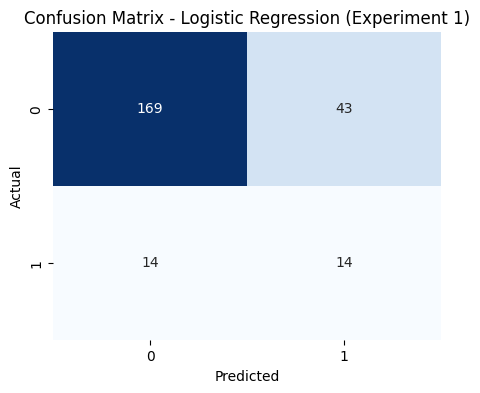

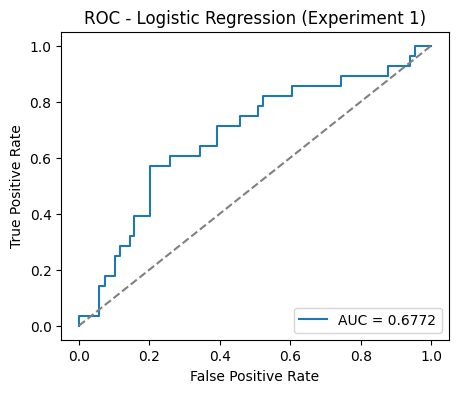

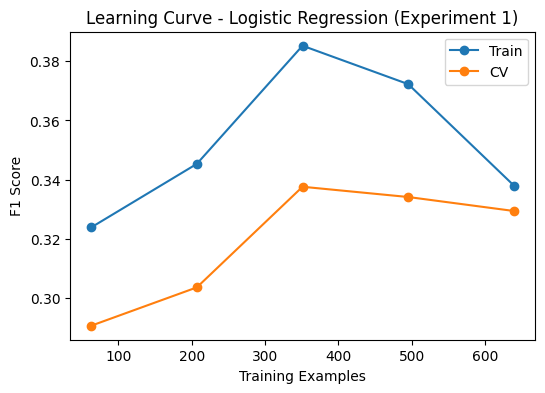


--- Logistic Regression Experiment 2: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': {0: 1, 1: 2.4}} ---
Metrics - Accuracy: 0.6125, F1: 0.2901, Precision: 0.1845, Recall: 0.6786
Best Threshold: 0.6000000000000001, Best F1: 0.3137


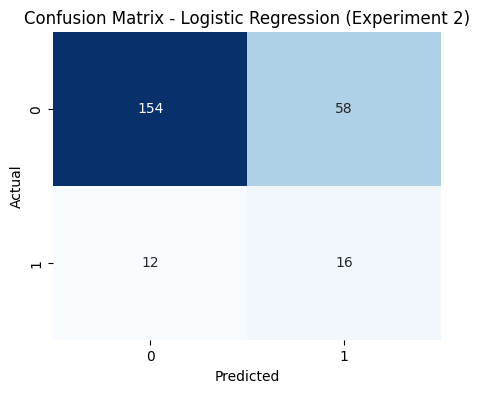

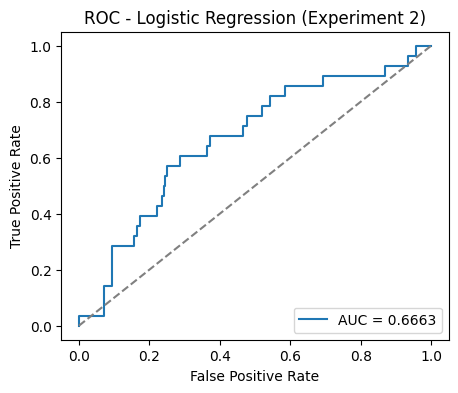

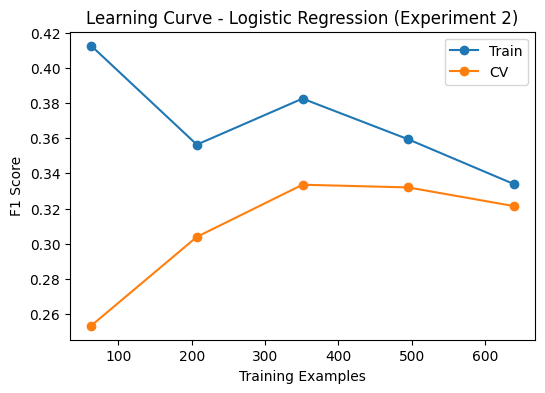


--- Logistic Regression Experiment 3: {'C': 10.0, 'penalty': 'l2', 'solver': 'saga', 'class_weight': None} ---
Metrics - Accuracy: 0.7792, F1: 0.2740, Precision: 0.2222, Recall: 0.3571
Best Threshold: 0.4000000000000001, Best F1: 0.3299


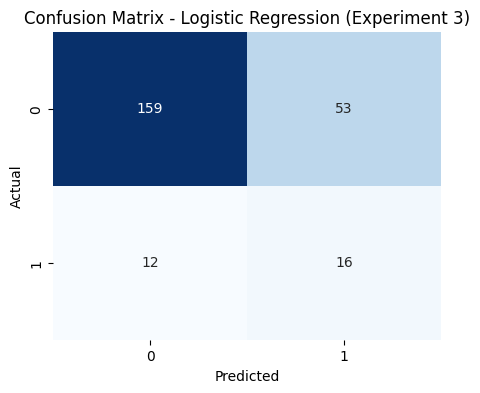

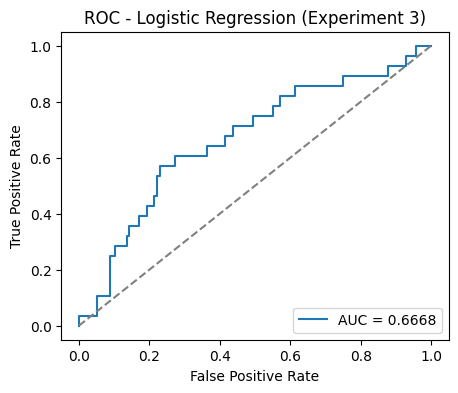

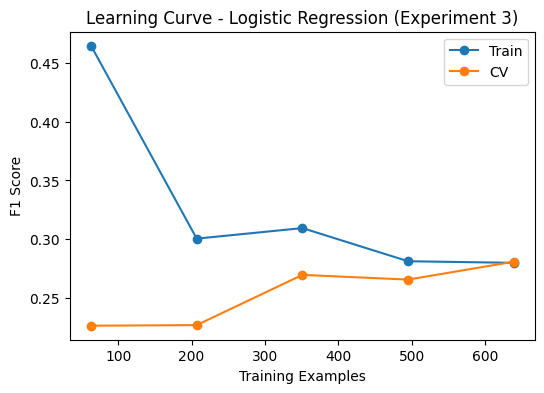


--- Logistic Regression Experiment 4: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'} ---
Metrics - Accuracy: 0.6708, F1: 0.3361, Precision: 0.2198, Recall: 0.7143
Best Threshold: N/A, Best F1: 0.3361


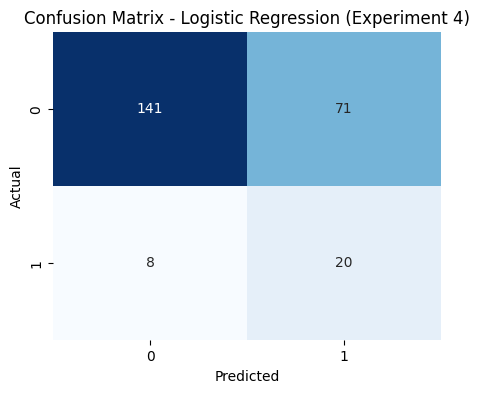

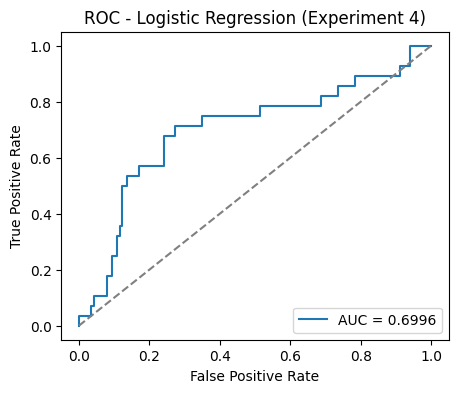

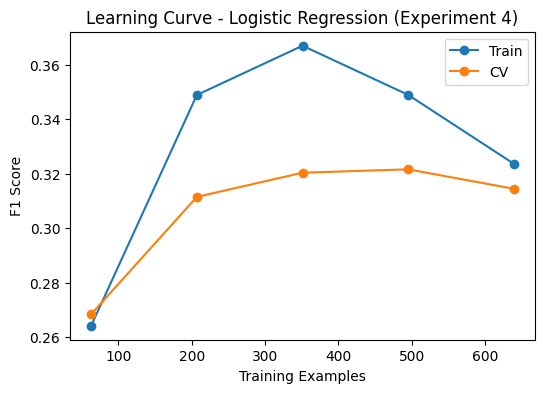


Logistic Regression Hyperparameter Configurations:
  Experiment     C   class_weight penalty    solver  Accuracy     F1  Precision  Recall Best Threshold  Best F1
Experiment 1  0.10       balanced      l2 liblinear    0.7625 0.2906     0.2456  0.5000            0.6   0.3294
Experiment 2  1.00 {0: 1, 1: 2.4}      l1 liblinear    0.7083 0.2901     0.2162  0.5714            0.6   0.3137
Experiment 3 10.00           None      l2      saga    0.7292 0.2740     0.2319  0.5714            0.4   0.3299
Experiment 4  0.01       balanced      l2 liblinear    0.6708 0.3361     0.2198  0.7143            N/A   0.3361


In [ ]:
lr_params_list = [
    {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'},
    {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': {0:1, 1:2.4}},
    {'C': 10.0, 'penalty': 'l2', 'solver': 'saga', 'class_weight': None},
    {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'}
]
# Run models
results = []
lr_best = train_and_evaluate(
    LogisticRegression(max_iter=1000),
    lr_params_list,
    X_train, X_test, y_train, y_test,
    model_name="Logistic Regression",
    scale_data=True
)
if lr_best:
    results.append(("Logistic Regression", lr_best))



üîç Training Random Forest with multiple param sets...
Minority class counts in Random Forest folds:
Fold 1: 75 minority samples
Fold 2: 75 minority samples
Fold 3: 76 minority samples
Fold 4: 75 minority samples
Fold 5: 75 minority samples
Fold 6: 76 minority samples
Fold 7: 75 minority samples
Fold 8: 75 minority samples
Fold 9: 76 minority samples
Fold 10: 75 minority samples
Fold 11: 75 minority samples
Fold 12: 76 minority samples
Fold 13: 75 minority samples
Fold 14: 75 minority samples
Fold 15: 76 minority samples

--- Random Forest Experiment 1: {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': 'balanced'} ---
Metrics - Accuracy: 0.7625, F1: 0.3736, Precision: 0.2698, Recall: 0.6071
Best Threshold: 0.6000000000000001, Best F1: 0.3896


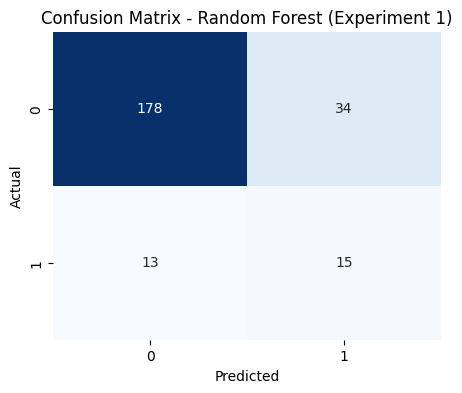

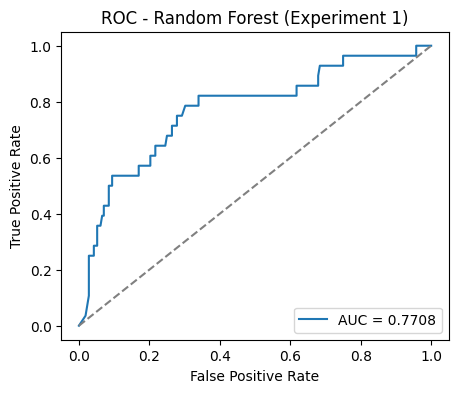

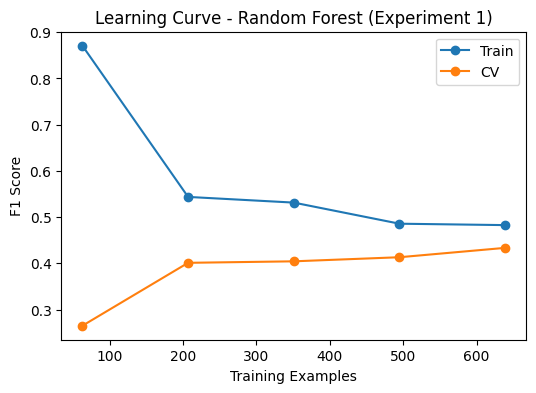


--- Random Forest Experiment 2: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'class_weight': {0: 1, 1: 2.4}} ---
Metrics - Accuracy: 0.7667, F1: 0.3778, Precision: 0.2742, Recall: 0.6071
Best Threshold: 0.7000000000000002, Best F1: 0.4643


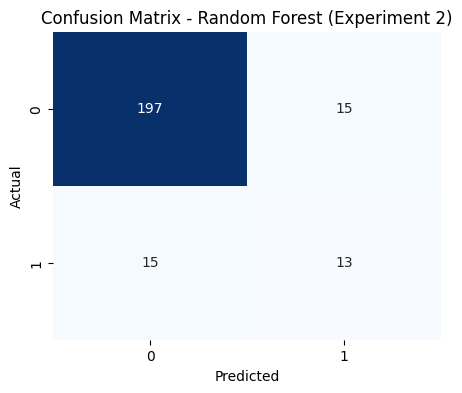

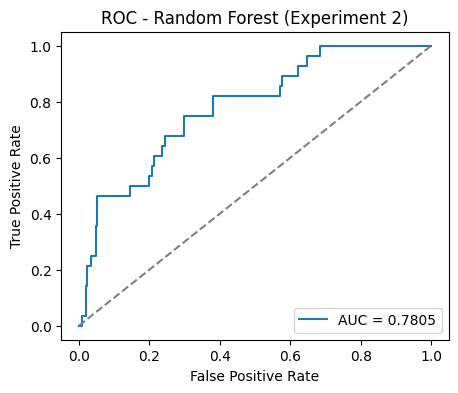

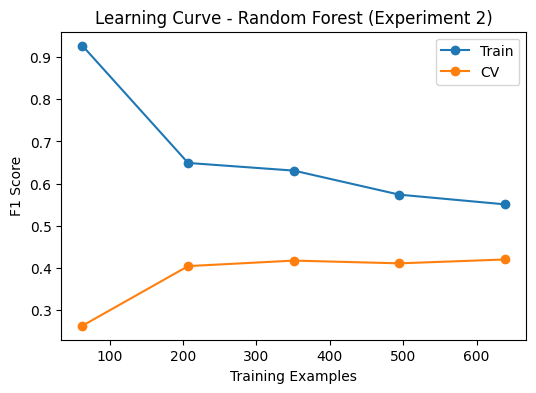


--- Random Forest Experiment 3: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'class_weight': None} ---
Metrics - Accuracy: 0.8750, F1: 0.4000, Precision: 0.4545, Recall: 0.3571
Best Threshold: 0.30000000000000004, Best F1: 0.4444


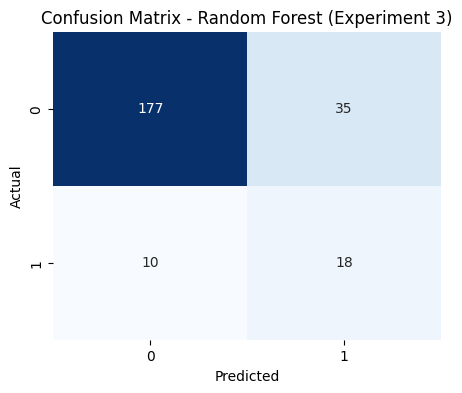

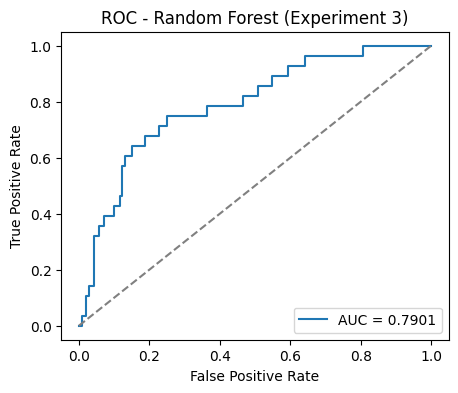

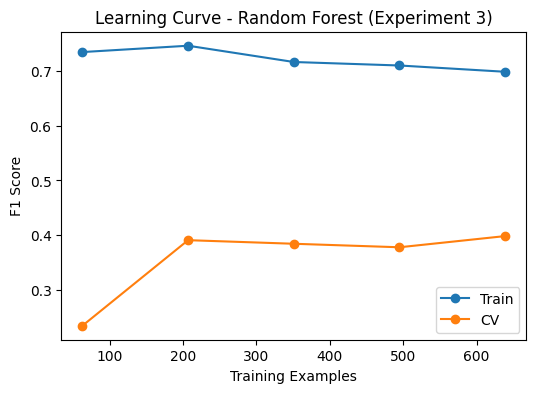


--- Random Forest Experiment 4: {'n_estimators': 150, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2, 'class_weight': 'balanced'} ---
Metrics - Accuracy: 0.8417, F1: 0.4062, Precision: 0.3611, Recall: 0.4643
Best Threshold: 0.6000000000000001, Best F1: 0.4483


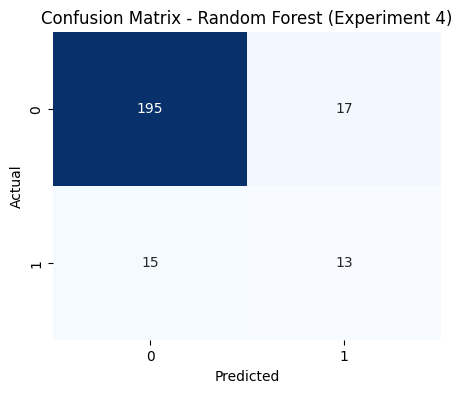

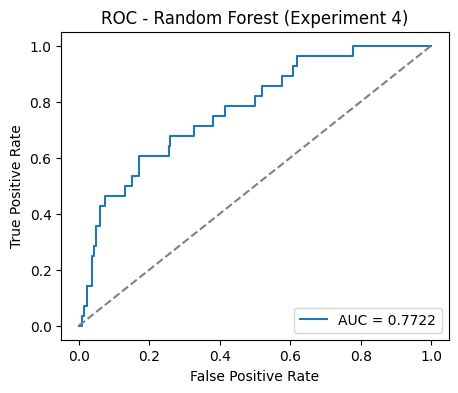

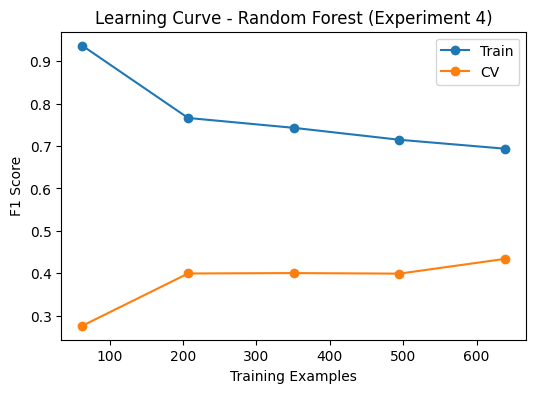


Random Forest Hyperparameter Configurations:
  Experiment   class_weight  max_depth  min_samples_leaf  min_samples_split  n_estimators  Accuracy     F1  Precision  Recall  Best Threshold  Best F1
Experiment 1       balanced          3                 1                  2            50    0.8042 0.3736     0.3061  0.5357             0.6   0.3896
Experiment 2 {0: 1, 1: 2.4}          5                 2                  5           100    0.8750 0.3778     0.4643  0.4643             0.7   0.4643
Experiment 3           None         10                 4                 10           200    0.8125 0.4000     0.3396  0.6429             0.3   0.4444
Experiment 4       balanced          7                 2                  5           150    0.8667 0.4062     0.4333  0.4643             0.6   0.4483


In [ ]:
rf_params_list = [
    {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': 'balanced'},
    {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'class_weight': {0:1, 1:2.4}},
    {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'class_weight': None},
    {'n_estimators': 150, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2, 'class_weight': 'balanced'}
]
rf_best = train_and_evaluate(
    RandomForestClassifier(),
    rf_params_list,
    X_train, X_test, y_train, y_test,
    model_name="Random Forest",
    scale_data=False
)
if rf_best:
    results.append(("Random Forest", rf_best))


üîç Training SVM with multiple param sets...
Minority class counts in SVM folds:
Fold 1: 75 minority samples
Fold 2: 75 minority samples
Fold 3: 76 minority samples
Fold 4: 75 minority samples
Fold 5: 75 minority samples
Fold 6: 76 minority samples
Fold 7: 75 minority samples
Fold 8: 75 minority samples
Fold 9: 76 minority samples
Fold 10: 75 minority samples
Fold 11: 75 minority samples
Fold 12: 76 minority samples
Fold 13: 75 minority samples
Fold 14: 75 minority samples
Fold 15: 76 minority samples

--- SVM Experiment 1: {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'probability': True} ---
Metrics - Accuracy: 0.6333, F1: 0.2787, Precision: 0.1809, Recall: 0.6071
Best Threshold: 0.4000000000000001, Best F1: 0.3441


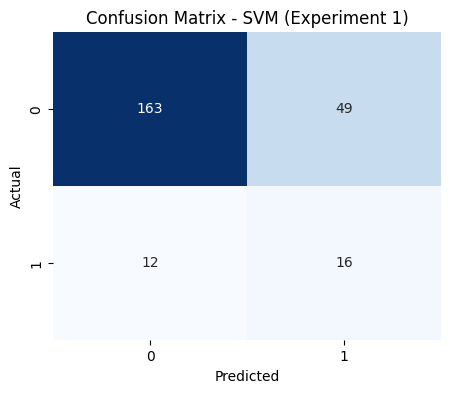

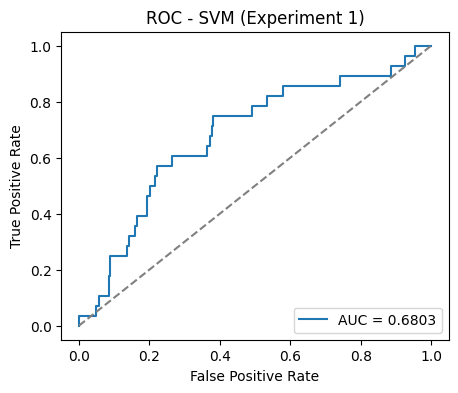

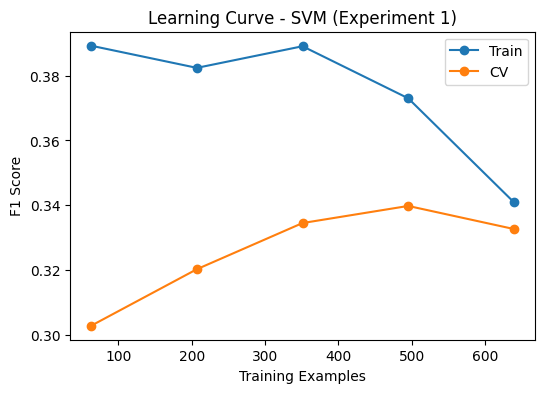


--- SVM Experiment 2: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': {0: 1, 1: 2.4}, 'probability': True} ---
Metrics - Accuracy: 0.7000, F1: 0.3208, Precision: 0.2179, Recall: 0.6071
Best Threshold: 0.5000000000000001, Best F1: 0.4051


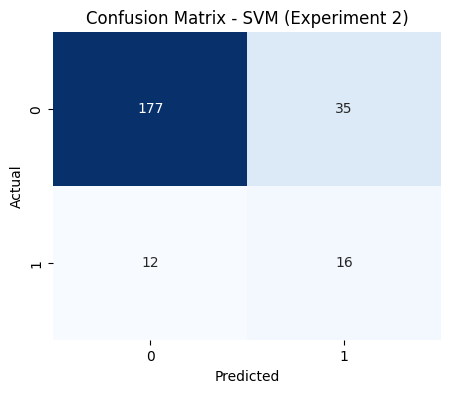

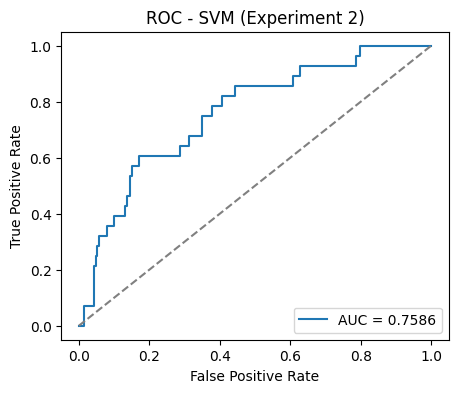

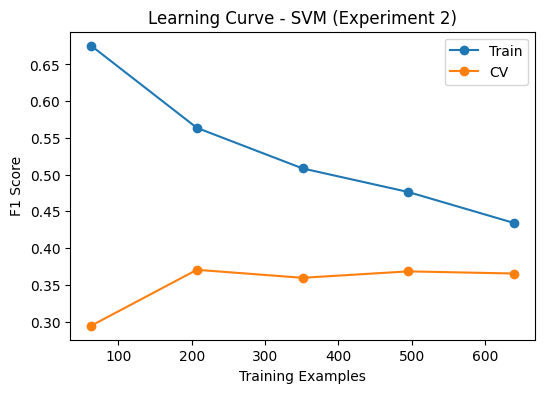


--- SVM Experiment 3: {'C': 10.0, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'probability': True} ---
Metrics - Accuracy: 0.8292, F1: 0.4225, Precision: 0.3488, Recall: 0.5357
Best Threshold: 0.4000000000000001, Best F1: 0.4324


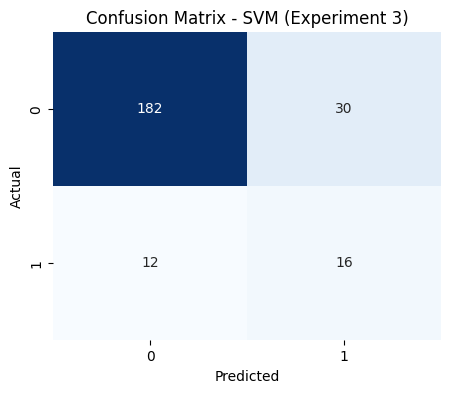

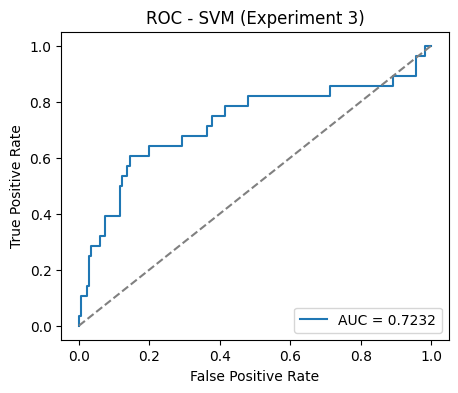

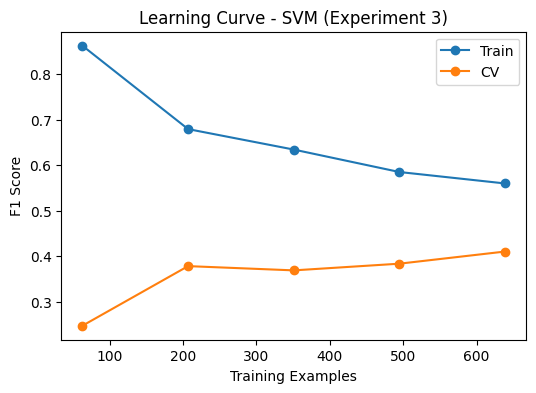


--- SVM Experiment 4: {'C': 0.5, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'probability': True} ---
Metrics - Accuracy: 0.6375, F1: 0.2810, Precision: 0.1828, Recall: 0.6071
Best Threshold: 0.4000000000000001, Best F1: 0.3158


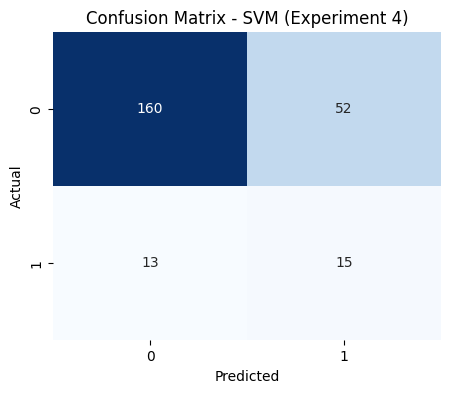

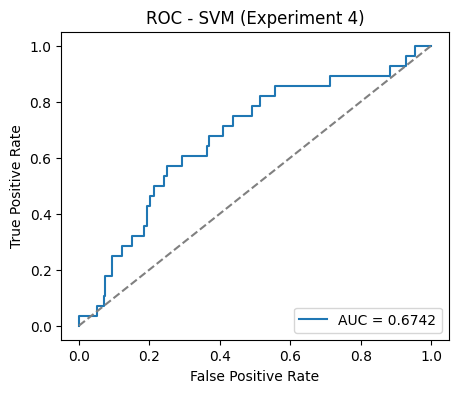

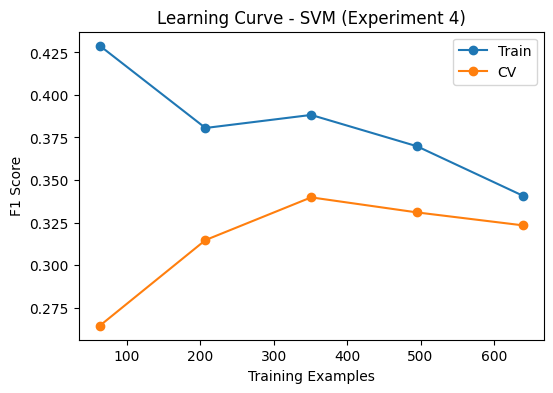


SVM Hyperparameter Configurations:
  Experiment    C   class_weight gamma kernel  probability  Accuracy     F1  Precision  Recall  Best Threshold  Best F1
Experiment 1  0.1       balanced scale linear         True    0.7458 0.2787     0.2462  0.5714             0.4   0.3441
Experiment 2  1.0 {0: 1, 1: 2.4} scale    rbf         True    0.8042 0.3208     0.3137  0.5714             0.5   0.4051
Experiment 3 10.0           None  auto    rbf         True    0.8250 0.4225     0.3478  0.5714             0.4   0.4324
Experiment 4  0.5       balanced scale linear         True    0.7292 0.2810     0.2239  0.5357             0.4   0.3158


In [ ]:
svm_params_list = [
    {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'probability': True},
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': {0:1, 1:2.4}, 'probability': True},
    {'C': 10.0, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'probability': True},
    {'C': 0.5, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'probability': True}
]
svm_best = train_and_evaluate(
    SVC(),
    svm_params_list,
    X_train, X_test, y_train, y_test,
    model_name="SVM",
    scale_data=True
)
if svm_best:
    results.append(("SVM", svm_best))


üîç Training XGBoost with multiple param sets...
Minority class counts in XGBoost folds:
Fold 1: 75 minority samples
Fold 2: 75 minority samples
Fold 3: 76 minority samples
Fold 4: 75 minority samples
Fold 5: 75 minority samples
Fold 6: 76 minority samples
Fold 7: 75 minority samples
Fold 8: 75 minority samples
Fold 9: 76 minority samples
Fold 10: 75 minority samples
Fold 11: 75 minority samples
Fold 12: 76 minority samples
Fold 13: 75 minority samples
Fold 14: 75 minority samples
Fold 15: 76 minority samples

--- XGBoost Experiment 1: {'n_estimators': 50, 'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 1} ---
Metrics - Accuracy: 0.8833, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Best Threshold: 0.4000000000000001, Best F1: 0.3636


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


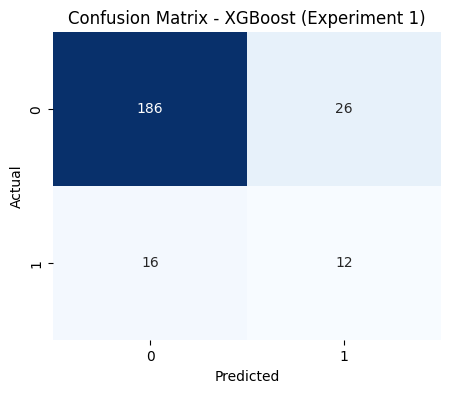

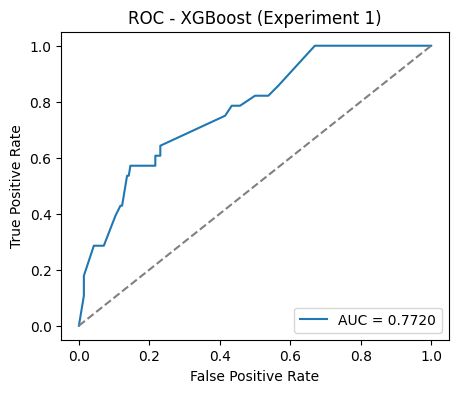

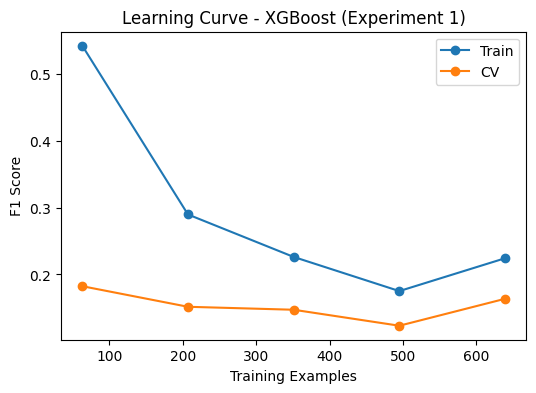


--- XGBoost Experiment 2: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 2.4} ---
Metrics - Accuracy: 0.8083, F1: 0.3611, Precision: 0.2955, Recall: 0.4643
Best Threshold: 0.6000000000000001, Best F1: 0.3636


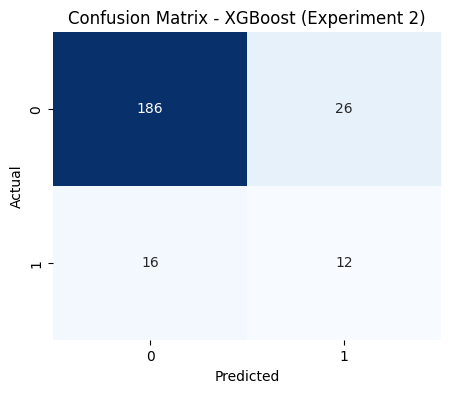

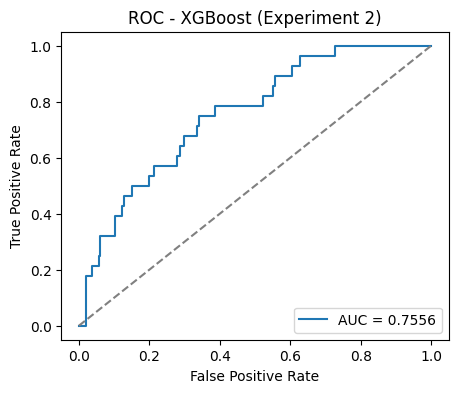

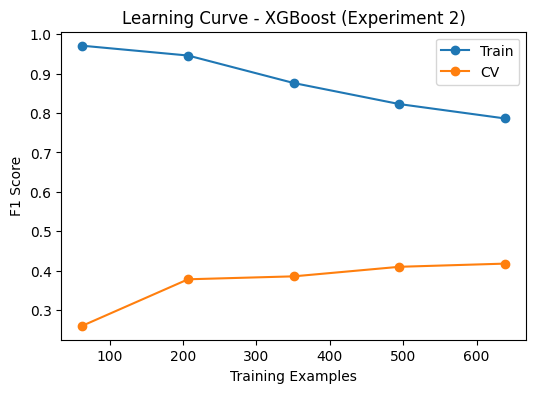


--- XGBoost Experiment 3: {'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 7, 'scale_pos_weight': 4} ---
Metrics - Accuracy: 0.8458, F1: 0.3019, Precision: 0.3200, Recall: 0.2857
Best Threshold: 0.4000000000000001, Best F1: 0.3158


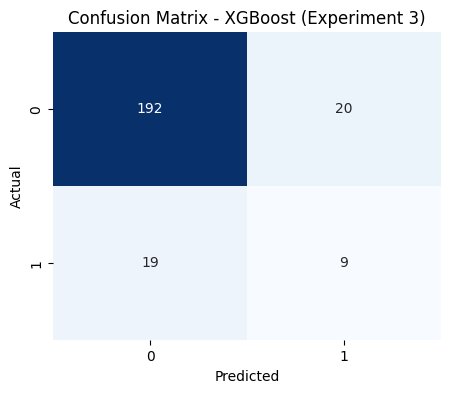

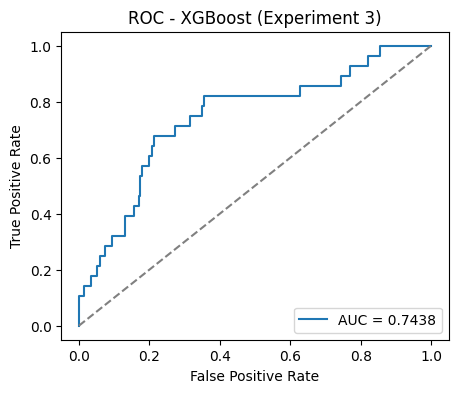

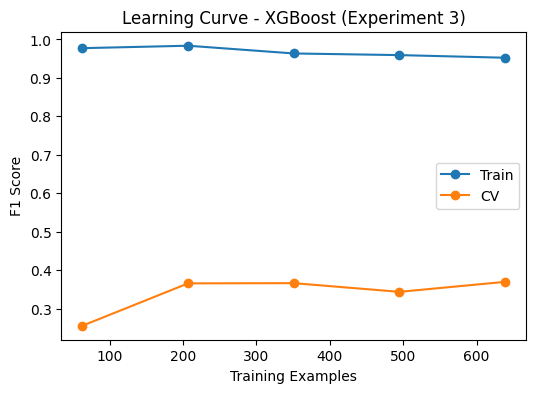


--- XGBoost Experiment 4: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 4, 'scale_pos_weight': 2} ---
Metrics - Accuracy: 0.8083, F1: 0.3947, Precision: 0.3125, Recall: 0.5357
Best Threshold: 0.4000000000000001, Best F1: 0.3956


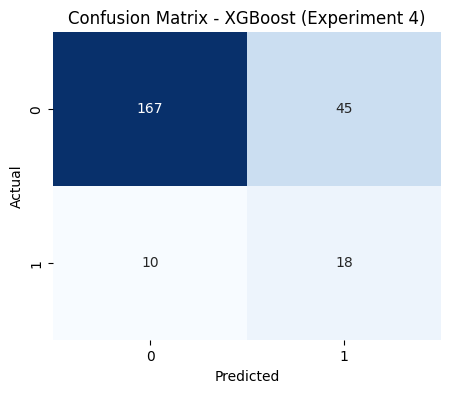

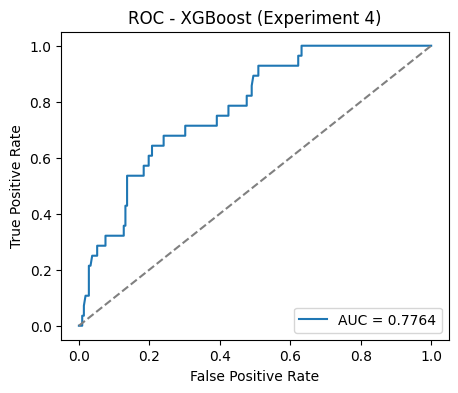

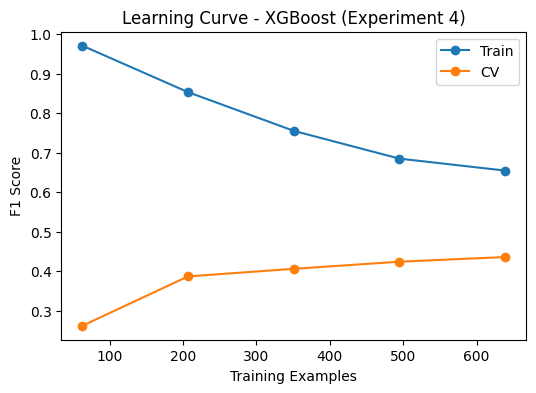


XGBoost Hyperparameter Configurations:
  Experiment  learning_rate  max_depth  n_estimators  scale_pos_weight  Accuracy     F1  Precision  Recall  Best Threshold  Best F1
Experiment 1           0.01          3            50               1.0    0.8250 0.0000     0.3158  0.4286             0.4   0.3636
Experiment 2           0.10          5           100               2.4    0.8250 0.3611     0.3158  0.4286             0.6   0.3636
Experiment 3           0.20          7           200               4.0    0.8375 0.3019     0.3103  0.3214             0.4   0.3158
Experiment 4           0.05          4           150               2.0    0.7708 0.3947     0.2857  0.6429             0.4   0.3956


In [ ]:
xgb_params_list = [
    {'n_estimators': 50, 'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 1},
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 2.4},
    {'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 7, 'scale_pos_weight': 4},
    {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 4, 'scale_pos_weight': 2}
]

# Run XGBoost
xgb_results = train_and_evaluate(
    XGBClassifier(eval_metric="logloss"),
    xgb_params_list,
    X_train, X_test, y_train, y_test,
    model_name="XGBoost"
)

In [ ]:
import joblib
model = lr_scores['best_model']
joblib.dump(model, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

In [ ]:
print("\nModel Comparison:")
for model_name, scores in [("Logistic Regression", lr_scores), ("Random Forest", rf_scores), ("SVM", svm_scores), ("XGBoost", xgb_scores)]:
    if scores is not None:
        print(f"{model_name}: Accuracy={scores['accuracy']:.4f}, F1={scores['f1']:.4f}, Precision={scores['precision']:.4f}, Recall={scores['recall']:.4f}")


Model Comparison:
Logistic Regression: Accuracy=0.7375, F1=0.2881, Precision=0.2308, Recall=0.5357
Random Forest: Accuracy=0.8500, F1=0.3896, Precision=0.3824, Recall=0.4643
SVM: Accuracy=0.8167, F1=0.3542, Precision=0.3182, Recall=0.5000
XGBoost: Accuracy=0.7792, F1=0.3908, Precision=0.2881, Recall=0.6071


In [ ]:
table_data = []
for model_name, scores in results:
    if scores is not None:
        row = {
            "Model": model_name,
            "Accuracy": scores["Accuracy"],
            "F1": scores["F1"],
            "Precision": scores["Precision"],
            "Recall": scores["Recall"],
            "Best Threshold": scores.get("Best Threshold", "N/A"),
            "Best F1": scores.get("Best F1", scores["F1"]),
            "Parameters": scores["Parameters"]
        }
        table_data.append(row)

# Convert to DataFrame
results_df = pd.DataFrame(table_data)
results_df = results_df.round(4)
print("\nModel Comparison Table (Best Configurations):")
print(results_df.to_string(index=False))

# Save to CSV
results_df.to_csv('model_comparison_best.csv', index=False)

# Instructions for manual saving
print("\nTo save a model, use joblib.dump. Example:")
print("import joblib")
print("joblib.dump(results[0][1]['best_model'], 'logistic_regression_model.pkl')  # For Logistic Regression")
print("Available models:", [model_name for model_name, _ in results])


Model Comparison Table (Best Configurations):
              Model  Accuracy     F1  Precision  Recall Best Threshold  Best F1                                                                                          Parameters
Logistic Regression    0.6708 0.3361     0.2198  0.7143            N/A   0.3361                                         C=0.01, penalty=l2, solver=liblinear, class_weight=balanced
      Random Forest    0.8750 0.3778     0.4643  0.4643            0.7   0.4643 n_estimators=100, max_depth=5, min_samples_split=5, min_samples_leaf=2, class_weight={0: 1, 1: 2.4}
                SVM    0.8250 0.4225     0.3478  0.5714            0.4   0.4324                                 C=10.0, kernel=rbf, gamma=auto, class_weight=None, probability=True

To save a model, use joblib.dump. Example:
import joblib
joblib.dump(results[0][1]['best_model'], 'logistic_regression_model.pkl')  # For Logistic Regression
Available models: ['Logistic Regression', 'Random Forest', 'SVM']
